In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from keras.callbacks import EarlyStopping
from keras.layers import Dense
from keras.models import Sequential
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_absolute_percentage_error as MAPE
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import train_test_split as tts
from sklearn.preprocessing import MinMaxScaler as mms
from tqdm.keras import TqdmCallback
import keras

# Import Data and Display Column names

In [2]:
url = 'http://apmonitor.com/pds/uploads/Main/automotive.txt'
data = pd.read_csv(url)
data.rename(columns={'Calculated instant fuel consumption (MPG)':"MPG"},inplace=True)
data.columns

Index(['time', 'Average fuel consumption (MPG)',
       'Average fuel consumption (total) (MPG)',
       'Average fuel consumption 10 sec (MPG)', 'Average speed (mph)', 'MPG',
       'Calculated instant fuel rate (gal./h)', 'Distance travelled (miles)',
       'Distance travelled (total) (miles)', 'Engine RPM (rpm)',
       'Fuel economizer (based on fuel system status and throttle position) ()',
       'Fuel used (gallon)', 'Fuel used (total) (gallon)',
       'Fuel used price ($)', 'Fuel used price (total) ($)',
       'Instant engine power (based on fuel consumption) (hp)',
       'MAF air flow rate (g/sec)',
       'Oxygen sensor 1 Wide Range Current (mA) (mA)',
       'Oxygen sensor 1 Wide Range Equivalence ratio ()',
       'Throttle position (%)', 'Vehicle acceleration (g)',
       'Vehicle speed (mph)', 'Unnamed: 22'],
      dtype='object')

# Reformat the Times to be Usable

In [3]:
from datetime import datetime

dtobj = datetime.strptime(data['time'].iloc[0],'%I:%M:%S.%f')
dtobj2 = datetime.strptime(data['time'].iloc[-1],'%I:%M:%S.%f')
dataf = data.copy()
dataf['time'] = data['time'].apply(func=lambda x: datetime.strptime(x,'%I:%M:%S.%f'))
dataf['timetot'] = dataf['time'].apply(lambda x:(x-dtobj).microseconds/10**6+(x-dtobj).seconds)
dataf['timetot'].sample(5)

38515    7022.985
20467    3782.845
6356     1022.783
12293    1986.128
43982    7910.532
Name: timetot, dtype: float64

# Plot and Visualize the Data

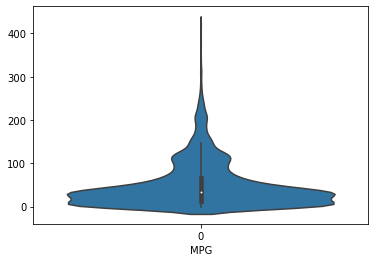

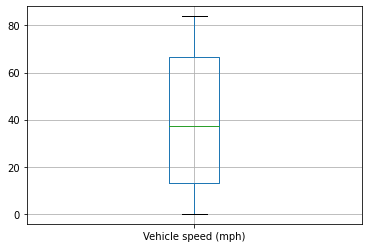

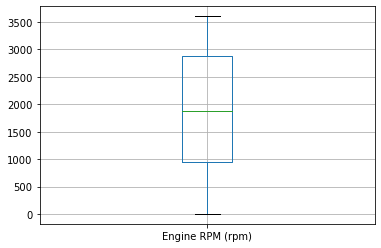

In [4]:
label = 'MPG'
#predict MPG from RPM, and speed
sns.violinplot(data=dataf[label])
plt.xlabel(label)
plt.show()
dataf.boxplot('Vehicle speed (mph)')
plt.show()
dataf.boxplot('Engine RPM (rpm)')
plt.show()

# Reformat Data
Here I chose to only use Vehicle Speed, Acceleration, and RPM as the features. These are the data most readily accessible by the driver and I hoped to create a model that will help the driver visualize the effects of different aspects of his/her driving on gas mileage.

In [5]:
rpm = 'Engine RPM (rpm)'
speed = 'Vehicle speed (mph)'
speeds = dataf[speed].dropna()
acel = 'Vehicle acceleration (g)'
gal = 'Fuel used (gallon)'
alls = [acel,speed,rpm,label]
dataf[alls].isna().sum()
datan = dataf[alls].copy().fillna(method='ffill').drop_duplicates()
datan = datan[datan[label]>0]
datan = datan[datan[label]<45] #Anything higher than this is most likely coasting
datan.sample(20)

,Vehicle acceleration (g),Vehicle speed (mph),Engine RPM (rpm),MPG
22904,0.018576,79.535513,3411.0,28.877027
46807,0.000000,1.864114,953.0,4.148738
45958,0.035673,40.389127,1735.0,18.207136
48893,-0.044699,8.699197,906.0,21.791121
9500,0.018512,70.836316,3050.0,25.328265
25232,0.054232,13.670166,1004.0,15.218809
34230,0.026793,37.903643,1647.0,16.985720
47406,-0.117353,13.048795,766.0,21.403882
10860,0.009483,68.350831,2931.0,32.370776
36984,0.019455,42.253241,1829.0,36.605468


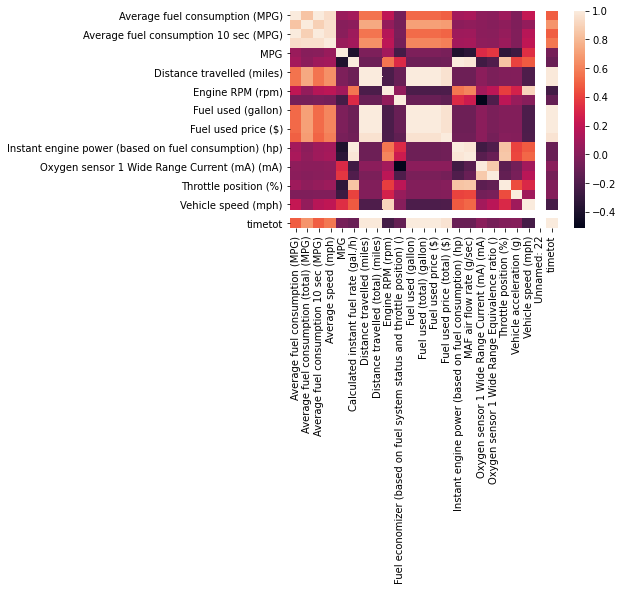

In [6]:
sns.heatmap(dataf.copy().fillna(method='ffill').drop_duplicates().corr(),annot=False,fmt='f')
plt.show()

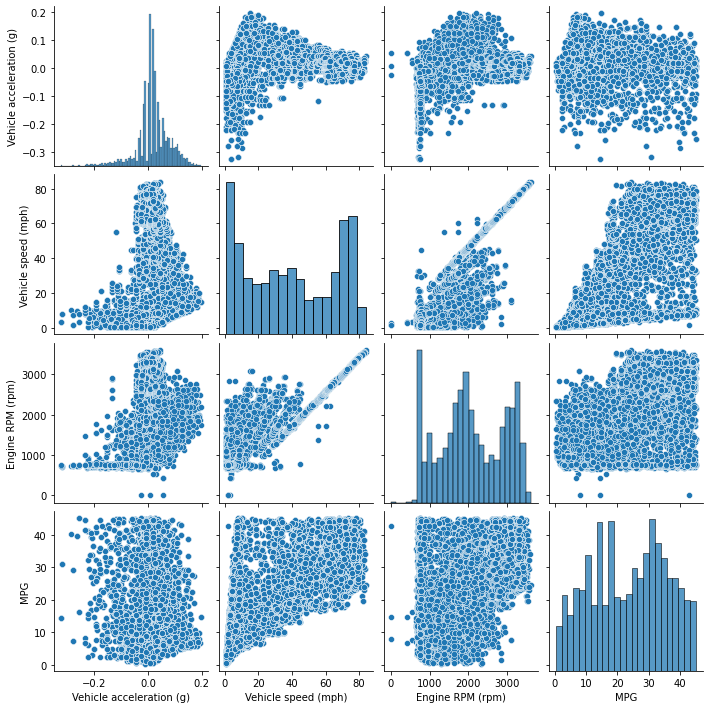

In [7]:
sns.pairplot(datan)

## Scale Data, Train model, and show accuracy

0.1501 2.978, r2=0.8816379734819699


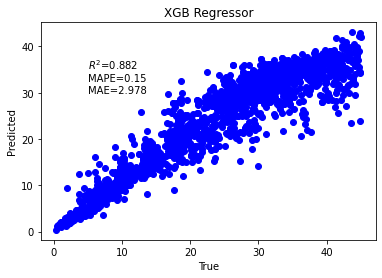

In [17]:
s = mms()

use = alls.copy()
use.remove('MPG')

dataS = pd.DataFrame(np.sqrt(np.array(s.fit_transform(datan))), columns =alls)
# dataS = dataS.copy()[dataS[label]<=2]
Xtrain, Xtest, ytrain, ytest = tts(dataS[use], dataS[label], test_size = .2, random_state = 87)

model = xgb.XGBRegressor()

m = model.fit(dataS[use], dataS[label])

datatest = Xtest.join(ytest,how='right')
yp = m.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform((datatest.values)**2),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap.values**2),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

#             r2score = r2(self.ytest[output],m.predict(self.xtest[bestin]))
scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.text(5,30,f'$R^2$={round(scorer,3)}\nMAPE={round(perc,3)}\nMAE={round(scoree,3)}')
plt.xlabel('True')
plt.ylabel('Predicted')
plt.title('XGB Regressor')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')
# linear model
reg = LinearRegression().fit(dataS[use], dataS[label])
ypr = reg.predict(datatest[use])
r2lin = r2(datatest[label],ypr)

# Create a NN to compare performance with XGBoost Regression

In [9]:
mod = Sequential()
mod.add(Dense(3,input_shape=(Xtrain.shape[1],),activation='relu'))
# mod.add(Dense(,activation='relu'))
# mod.add(Dense(32,activation='relu'))
# mod.add(Dense(3,activation='relu'))
# mod.add(Merge())
mod.add(Dense(1,activation='linear'))

mod.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 12        
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [20]:
# opti = Adam(lr=.01)
mod.compile(optimizer='sgd', loss='mse')
history = mod.fit(Xtrain,ytrain,epochs = 350, verbose=True, \
                  validation_data=(Xtest,ytest),\
                  callbacks=[TqdmCallback(verbose=1), \
                             EarlyStopping(monitor='loss',patience=10)])

Epoch 1/350
227/227 [==============================] - 0s 1ms/step - loss: 0.0167 - val_loss: 0.0163
Epoch 2/350
227/227 [==============================] - 0s 686us/step - loss: 0.0167 - val_loss: 0.0163
Epoch 3/350
227/227 [==============================] - 0s 708us/step - loss: 0.0167 - val_loss: 0.0162
Epoch 4/350
227/227 [==============================] - 0s 695us/step - loss: 0.0167 - val_loss: 0.0162
Epoch 5/350
227/227 [==============================] - 0s 708us/step - loss: 0.0167 - val_loss: 0.0163
Epoch 6/350
227/227 [==============================] - 0s 699us/step - loss: 0.0167 - val_loss: 0.0162
Epoch 7/350
227/227 [==============================] - 0s 717us/step - loss: 0.0167 - val_loss: 0.0163
Epoch 8/350
227/227 [==============================] - 0s 713us/step - loss: 0.0167 - val_loss: 0.0163
Epoch 9/350
227/227 [==============================] - 0s 686us/step - loss: 0.0167 - val_loss: 0.0165
Epoch 10/350
227/227 [==============================] - 0s 695us/step - los

### Plot Learning History

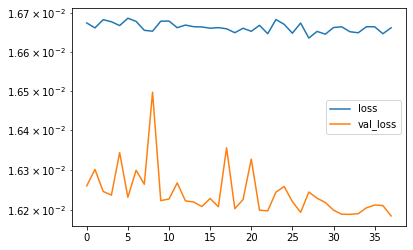

In [23]:
plt.semilogy(history.history['loss'],label='loss')
plt.semilogy(history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()
mod.save('Model_3var.h5')

0.1846 4.472, r2=0.6378650233201832


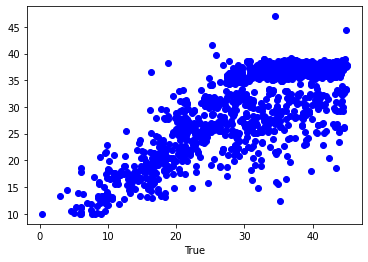

In [24]:
# datatest = Xtest.join(ytest,how='right')
mod = keras.models.load_model('Model_3var.h5')
yp = mod.predict(datatest[use])
unscaled = pd.DataFrame(s.inverse_transform(datatest),columns = alls)
datap = datatest.copy()
datap[label] = yp
unscaledy = unscaled[label]
unscaledp = pd.DataFrame(s.inverse_transform(datap),columns=alls)[label]
perc = MAPE(unscaledy, unscaledp)

#             r2score = r2(self.ytest[output],m.predict(self.xtest[bestin]))
scoree = MAE(unscaledy, unscaledp)
scorer = r2(unscaledy, unscaledp)
plt.plot(unscaledy, unscaledp, 'bo')
plt.xlabel('True')
print(f'{perc:.4g}',f'{scoree:.4g}, r2={scorer}')

# Visualize Predictions


RPM,Speed,Acceleration medians:
(0.7444, 0.6747, 0.8112)


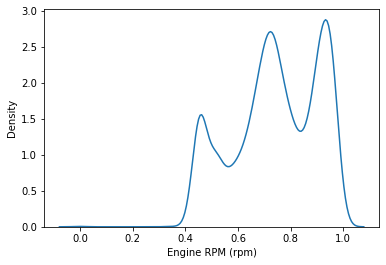

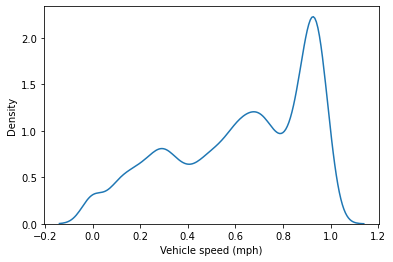

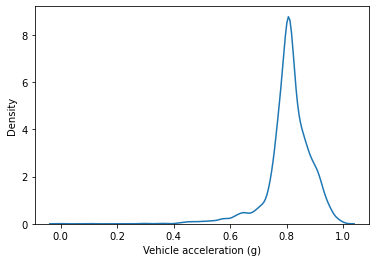

In [27]:
# XGB Regression
rpmmed = np.ones(datan.shape[0])*dataS[rpm].median()
speedmed = np.ones(datan.shape[0])*dataS[speed].median()
acelmed = np.ones(datan.shape[0])*dataS[acel].median()
print(f'RPM,Speed,Acceleration medians:\n{round(dataS[rpm].median(),4),round(dataS[speed].median(),4),round(dataS[acel].median(),4)}')
sns.kdeplot(dataS[rpm])
plt.show()
sns.kdeplot(dataS[speed])
plt.show()
sns.kdeplot(dataS[acel])
plt.show()

## Display Extrapolations with one variable

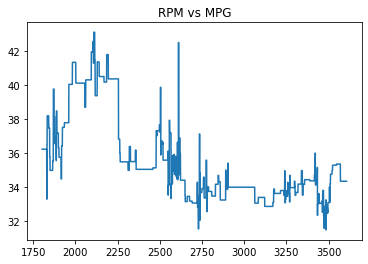

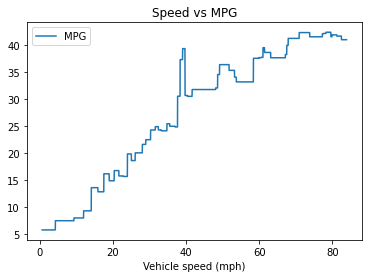

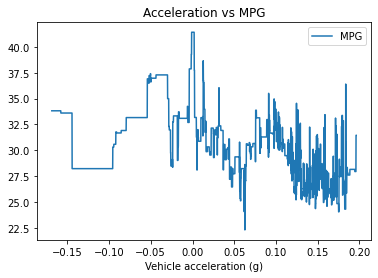

In [28]:
# Use the XGBoost model since it performed better
n = datan.shape[0]
rpmvar = np.linspace(.5,1,n)
speedvar = np.linspace(0,1,n)
acelvar = np.linspace(.3,1,n)
rpmdf = pd.DataFrame(np.array([acelmed,speedmed,rpmvar]).T,columns=use)
speeddf = pd.DataFrame(np.array([acelmed,speedvar,rpmmed]).T,columns=use)
aceldf = pd.DataFrame(np.array([acelvar,speedmed,rpmmed]).T,columns=use)
rpmpred = m.predict(rpmdf)
speedpred = m.predict(speeddf)
acelpred = m.predict(aceldf)
trrpm = pd.DataFrame(s.inverse_transform(rpmdf.join(pd.DataFrame(rpmpred))),columns = use+[label])
trspeed = pd.DataFrame(s.inverse_transform(speeddf.join(pd.DataFrame(speedpred))),columns = use+[label])
tracel = pd.DataFrame(s.inverse_transform(aceldf.join(pd.DataFrame(acelpred))),columns = use+[label])
plt.plot(trrpm[rpm],trrpm[label])
plt.title('RPM vs MPG')
plt.show()
trspeed.plot(x=speed,y=label)
plt.title('Speed vs MPG')
plt.show()
tracel.plot(x=acel,y=label)
plt.title('Acceleration vs MPG')
plt.show()

### You can, alternatively, plot the four dimensional figure. This gives you a better knowledge of the system across known cases, but often it is harder to understand.

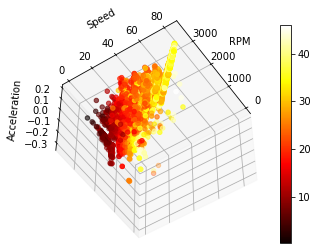

In [29]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
datass = dataS.copy()
datass[label] = m.predict(dataS[use])
datainv = pd.DataFrame(s.inverse_transform(datass),columns = use+[label])
img = ax.scatter(datainv[rpm],datainv[speed],datainv[acel],c=datainv[label],cmap = plt.hot())
fig.colorbar(img)
plt.xlabel('RPM')
plt.ylabel('Speed')
ax.set_zlabel('Acceleration')
#     plt.clf()
ax.view_init(azim=34,elev = -51)

plt.show()


# Conclusion
The above three cross sections show the MPG varying a single variable while the other variables are held constant at their median. This method inherently misses important behavior because the other values are hardly ever truly the median in real life. However, the trends are visible and most likely carry throughout portions of the 4-d model, even if their actual magnitudes vary.